In [1]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
import pandas as pd
import ta
import ccxt
import pandas_ta as pda

In [2]:
# pairList = pairJson['hitbtc2018']
pair = 'AVAX/USDT'
timeframe = '1h'
startDate = '2017-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='./database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)

Successfully load 12287 candles for AVAXUSDT


In [3]:
# -- Indicator variable --
trixLength = 9
trixSignal = 21
stochWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
df['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=df['close'], window=trixLength), window=trixLength), window=trixLength)
df['TRIX_PCT'] = df["TRIX"].pct_change()*100
df['TRIX_SIGNAL'] = ta.trend.sma_indicator(df['TRIX_PCT'], trixSignal)
df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=14, smooth1=3, smooth2=3)

df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=stochWindow)

print("Indicators loaded 100%")
df

Indicators loaded 100%


,open,high,low,close,volume,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,STOCH_RSI
timestamp,,,,,,,,,,
2020-09-22 06:00:00,0.8500,6.0000,0.850,4.8811,3198372.67,NaN,NaN,NaN,NaN,NaN
2020-09-22 07:00:00,4.8800,5.3500,4.245,4.9096,3171013.60,NaN,NaN,NaN,NaN,NaN
2020-09-22 08:00:00,4.9096,6.9289,4.820,6.8219,3883981.43,NaN,NaN,NaN,NaN,NaN
2020-09-22 09:00:00,6.8299,7.0000,5.550,6.2108,3681832.89,NaN,NaN,NaN,NaN,NaN
2020-09-22 10:00:00,6.2109,6.3000,4.975,5.4901,2729116.18,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-02-16 18:00:00,92.0600,93.1800,91.740,92.9500,73671.41,93.309933,0.049328,0.354345,-0.305017,0.107432
2022-02-16 19:00:00,92.9600,96.0700,92.500,95.8500,273219.95,93.354688,0.047965,0.338072,-0.290107,0.388142
2022-02-16 20:00:00,96.1500,96.2400,94.880,95.2600,101882.50,93.409392,0.058598,0.322044,-0.263446,0.307006


In [4]:
# -- Intern parameter --
dfTest = df['2017-01-01':]
#ndfTest = df[:]
startingBalance = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Rules --
StopLossActivation = False
takeProfitActivation = False
timeLimitActivation = False
showLog = False
waitNextSignal = False

# -- Hyper parameters --
stochOverBought = 0.85
stochOverSold = 0.25
SlPct = 0.02
TpPct = 0.02
timeLimit = 17


# -- Trade Functions --
# -- Condition to BUY market --

def buyCondition(row, previousRow):
    if (
        row['TRIX_HISTO'] >= 0
        and row['STOCH_RSI'] < stochOverBought
    ):
        return True
    else:
        return False

# -- Condition to SELL market --


def sellCondition(row, previousRow):
    if (
        row['TRIX_HISTO'] < 0
        and row['STOCH_RSI'] > stochOverSold
    ):
        return True
    else:
        return False


# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
buyReady = True
sellReady = True
currentTimeOpen = 0
timeSince = 0

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
    timeSince += 1
    if currentTimeOpen > 0:
        currentTimeOpen += 1
    # -- Buy market order --
    if buyCondition(row, previousRow) and usd > 0 and buyReady == True:
        # -- You can define here at what price you buy --
        buyPrice = row['close']

        # -- Define the price of you SL and TP or comment it if you don't want a SL or TP --
        if StopLossActivation:
            stopLoss = buyPrice - SlPct * buyPrice
        if takeProfitActivation:
            takeProfit = buyPrice + TpPct * buyPrice
        if timeLimitActivation:
            currentTimeOpen = 1

        fee = takerFee * usd
        usd = usd - fee
        coin = usd / buyPrice
        usd = 0
        wallet = coin * row['close']

        if showLog:
            print("Buy COIN at", buyPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Buy",
            'reason': 'Buy Market Order',
            'price': buyPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Take Profit --
    elif row['high'] > takeProfit and coin > 0:
        sellPrice = takeProfit
        usd = coin * sellPrice
        fee = makerFee * usd
        usd = usd - fee
        coin = 0
        wallet = usd

        if waitNextSignal:
            buyReady = False

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at Take Profit", sellPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Take Profit',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    # -- Stop Loss --
    elif row['low'] < stopLoss and coin > 0:
        sellPrice = stopLoss
        usd = coin * sellPrice
        fee = makerFee * usd
        usd = usd - fee
        coin = 0
        wallet = usd

        currentTimeOpen = 0

        if waitNextSignal:
            buyReady = False

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at Stop Loss", sellPrice, '$ the', index)
        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Stop Loss',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Sell Market Order --
    elif sellCondition(row, previousRow):
        buyReady = True
        if coin > 0:
            # -- You can define here at what price you buy --
            sellPrice = row['close']
            usd = coin * sellPrice
            fee = takerFee * usd
            usd = usd - fee
            coin = 0
            # buyReady = True
            wallet = usd

            # -- You can uncomment the line below if you want to see logs --
            if showLog:
                print("Sell COIN at", sellPrice, '$ the', index)

            # -- Add the trade to DfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Sell",
                'reason': 'Sell Market Order',
                'price': sellPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet,
                'timeSince': timeSince
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)
            timeSince = 0

    elif currentTimeOpen > timeLimit and coin > 0:
        sellPrice = row['close']
        usd = coin * sellPrice
        fee = takerFee * usd
        usd = usd - fee
        coin = 0
        if waitNextSignal:
            buyReady = False
        wallet = usd

        # -- You can uncomment the line below if you want to see logs --
        if showLog:
            print("Sell COIN at", sellPrice, '$ the', index)

        # -- Add the trade to DfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Sell",
            'reason': 'Sell Time Market Order',
            'price': sellPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    previousRow = row

print("Final wallet", wallet)
print(dfTrades)


Final wallet 27101.576007102452
                   date position             reason    price      frais  \
0   2020-09-24 06:00:00      Buy   Buy Market Order   3.6800   0.700000   
1   2020-09-25 12:00:00     Sell  Sell Market Order   4.4149   0.839203   
2   2020-09-26 23:00:00      Buy   Buy Market Order   4.5200   0.838615   
3   2020-09-27 14:00:00     Sell  Sell Market Order   4.2631   0.790398   
4   2020-09-28 00:00:00      Buy   Buy Market Order   4.5656   0.789845   
..                  ...      ...                ...      ...        ...   
655 2022-02-13 20:00:00     Sell  Sell Market Order  79.4400  16.048823   
656 2022-02-14 09:00:00      Buy   Buy Market Order  77.8600  16.037589   
657 2022-02-15 22:00:00     Sell  Sell Market Order  90.5100  18.630183   
658 2022-02-16 03:00:00      Buy   Buy Market Order  93.9300  18.617142   
659 2022-02-16 19:00:00     Sell  Sell Market Order  95.8500  18.984392   

             fiat       coins        wallet timeSince  
0          

In [5]:
BTobject = Backtesting()
newDf = BTobject.simple_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTest, pairSymbol=pair, timeframe=timeframe)

Pair Symbol : AVAX/USDT | Timeframe : 1h
Period : [2020-09-22 06:00:00] -> [2022-02-16 22:00:00]
Starting balance : 999.3 $

----- General Informations -----
Final balance : 27101.58 $
Performance vs US Dollar : 2612.06 %
Buy and Hold Performence : 1863.7 %
Performance vs Buy and Hold : 38.11 %
Best trade : +84.38 %, the 2021-02-10 21:00:00
Worst trade : -32.85 %, the 2021-05-23 17:00:00
Worst drawDown : - 54.34 %
Total fees :  4748.03 $

----- Trades Informations -----
Total trades on period : 330
Number of positive trades : 150
Number of negative trades :  180
Trades win rate ratio : 45.45 %
Average trades performance : 1.47 %
Average positive trades : 7.79 %
Average negative trades : -3.81 %

----- Time Informations -----
Average time duration for a trade : 19.93 periods
Maximum time duration for a trade : 61 periods
Minimum time duration for a trade : 1 periods
Average time duration between two trades : 17.29 periods
Maximum time duration between two trades : 59 periods
Minimum tim

----- 2020 Performances: -25.13% -----


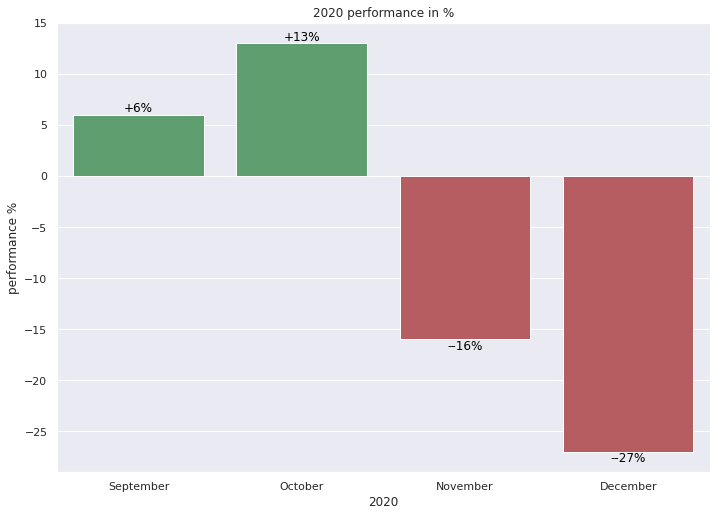

----- 2021 Performances: 2802.97% -----


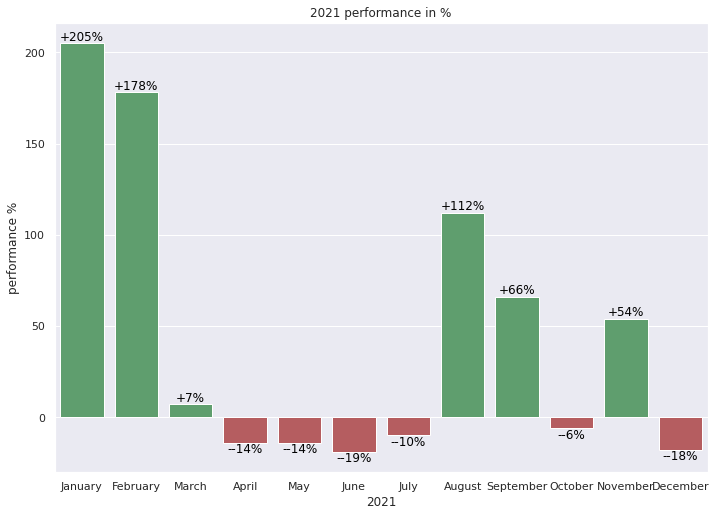

----- 2022 Performances: 20.13% -----


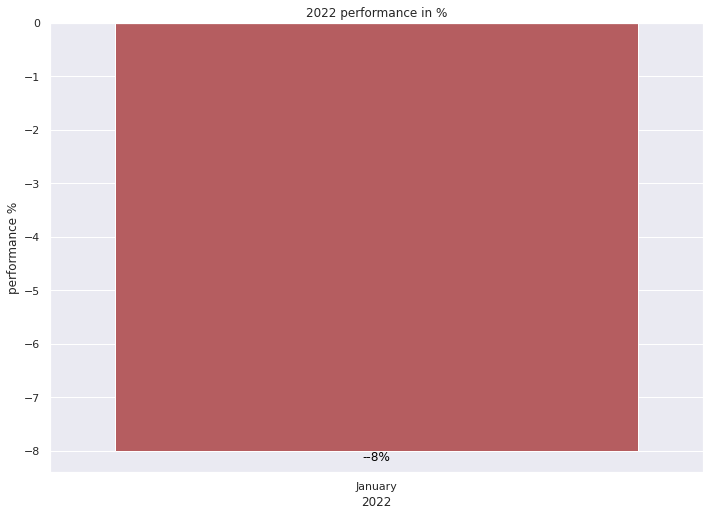

In [6]:
BTobject.plot_bar_by_month(dfTrades=dfTrades)


----- Plot -----


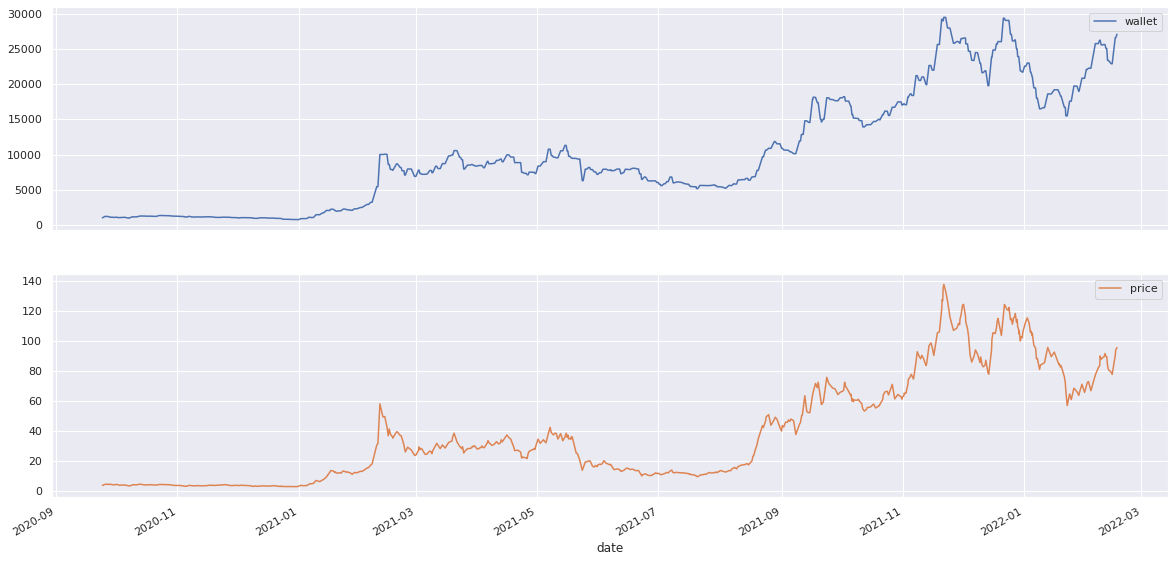

In [7]:
BTobject.plot_wallet_vs_price(dfTrades=dfTrades)